In [ ]:
## The data for earnings have not been uploaded for trading sensitivity. 
## Library Packages 
%run libraries.py 
from __future__ import division
from tsfresh import extract_features

# Settings 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
seed = 7
np.random.seed(seed)

import warnings
warnings.filterwarnings('ignore')


np.set_printoptions(threshold=np.nan)

!free -h

             total       used       free     shared    buffers     cached
Mem:          125G        20G       105G        12M       1.2G        15G
-/+ buffers/cache:       3.7G       122G
Swap:          15G       1.6G        14G


In [ ]:
# Clean and filter Analysts

analyst = pd.read_csv("analysts.csv")
analyst_1 = analyst.rename(columns={"OFTIC":"ticker", "FPEDATS":"qtrdat", "ANNDATS":"anndat", "ANNTIMS":"anntim",
                              "VALUE":"estimate"})
analyst_1["iters"] = analyst_1['ticker']+analyst_1['qtrdat'].astype(str)
print(analyst_1.shape, len(analyst_1["ticker"].unique()),len(pd.unique(analyst_1["iters"])))
# Wow it removes a lot of values, I would not have expected, read to make sure. 
analyst_1 = analyst_1.drop_duplicates(subset=["ESTIMATOR","ANALYS","qtrdat","ticker"],keep='last')
print(analyst_1.shape, len(analyst_1["ticker"].unique()),len(pd.unique(analyst_1["iters"])))

print(analyst_1.shape, len(analyst_1["ticker"].unique()),len(pd.unique(analyst_1["iters"])))
analyst_1 = analyst_1[analyst_1["anndat"]<analyst_1["ANNDATS_ACT"]].reset_index(drop=True)
print(analyst_1.shape, len(analyst_1["ticker"].unique()),len(pd.unique(analyst_1["iters"])))
# Wow that is quite a lot of firms, glad I got rid of that. 

#Also remove where actual is nulle
print(analyst_1["ACTUAL"].isnull().sum())
analyst_1 = analyst_1[~analyst_1["ACTUAL"].isnull()].reset_index(drop=True)
print(analyst_1.shape, len(analyst_1["ticker"].unique()),len(pd.unique(analyst_1["iters"])))

analyst_1['anndat'] = pd.to_datetime(analyst_1['anndat'].astype(str), format='%Y%m%d')
analyst_1['ANNDATS_ACT'] = pd.to_datetime(analyst_1['ANNDATS_ACT'].astype(str), format='%Y%m%d')

analyst_2 = analyst_1[((analyst_1["ANNDATS_ACT"]-analyst_1["anndat"]).dt.days).astype(int)<(60)].reset_index(drop=True)
print(analyst_2.shape, len(analyst_2["ticker"].unique()),len(pd.unique(analyst_2["iters"])))
# Want to incorporate a new one that says the estimate had to have been made within two months. 
# It feels more fare but it is a big break
# One month is stupid it dropped 90% so I will make it two months. 
print(analyst_2["ANNDATS_ACT"].min(),analyst_2["ANNDATS_ACT"].max())

analyst_2 = analyst_2[~analyst_2["ticker"].isnull()]
print(analyst_2.shape, len(analyst_2["ticker"].unique()),len(pd.unique(analyst_2["iters"]))) # Where there is no ticker available
analyst_2 = analyst_2[~analyst_2["estimate"].isnull()]
print(analyst_2.shape, len(analyst_2["ticker"].unique()),len(pd.unique(analyst_2["iters"]))) # No estimate available

# The number of observations fell about 60%, not too bad, average analyst 2.1

# Analyst ratings to be fed into Time Series
analyst_4 = analyst_2.drop_duplicates(subset=["anndat","ticker"],keep='last')
# I want more than 12 earnings reported.
ticks = analyst_2[["iters","ticker"]].groupby("ticker").count()
ticks = ticks[ticks["iters"]>39]
# del analyst_1

analyst_2 = analyst_2[analyst_2["ticker"].isin(ticks.index.values)].reset_index(drop=True)


In [ ]:
analyst_2.head()

In [ ]:
# Creation of big summary information to serve as target

big = analyst_2[["estimate","ticker","ANNDATS_ACT"]].groupby(["ticker","ANNDATS_ACT"]).mean().reset_index()
big["est_std"] = analyst_2[["estimate","ticker","ANNDATS_ACT"]].groupby(["ticker","ANNDATS_ACT"]).std().reset_index()["estimate"]
big["est_count"] = analyst_2[["estimate","ticker","ANNDATS_ACT"]].groupby(["ticker","ANNDATS_ACT"]).count().reset_index()["estimate"]
big = big.rename(columns={"estimate":"est_avg"})

# Add some extra info 

big["est_std"] = big["est_std"].fillna(method="ffill")
big = pd.merge(big, analyst_2[["ticker","ANNDATS_ACT","qtrdat","ACTUAL"]].drop_duplicates(keep="last"), on=["ticker","ANNDATS_ACT"],how="left")
print(big.shape)
big.head()

In [ ]:
# Clean Daily

daily = pd.read_csv("daily.csv")
daily = daily.rename(columns={"GVKEY":"gvkey",  "tic":"ticker",
                              "cusip":"cusip","conm":"coyn", "cshtrd":"volume",
                              "prccd":"close","prchd":"high","prcld":"low",
                              "prcod":"open","prcstd":"prcstd","idbflag":"idbflag",
                              "spcseccd":"spcseccd","ipodate":"ipodate"}) 

daily = daily.drop("iid",axis=1)
daily = daily.sort_values(["gvkey","datadate"]
                         )

daily['datadate'] = pd.to_datetime(daily['datadate'].astype(str), format='%Y%m%d')
print(daily.shape)
daily.head()

In [ ]:
d_a = pd.merge(daily,big, left_on=["ticker","datadate"], right_on=["ticker","ANNDATS_ACT"],how="left")
d_a = d_a.reset_index(drop=True)

In [ ]:
d_a["ANNDATS_ACT"] = d_a[["ANNDATS_ACT","gvkey"]].groupby(["gvkey"]).bfill()

d_a["est_avg"] = d_a[["est_avg","gvkey"]].groupby(["gvkey"]).bfill()
d_a["est_std"] = d_a[["est_std","gvkey"]].groupby(["gvkey"]).bfill()
d_a["est_count"] = d_a[["est_count","gvkey"]].groupby(["gvkey"]).bfill()
d_a["ACTUAL"] = d_a[["ACTUAL","gvkey"]].groupby(["gvkey"]).bfill()
d_a["qtrdat"] = d_a[["qtrdat","gvkey"]].groupby(["gvkey"]).bfill()

d_a = d_a[~d_a["ANNDATS_ACT"].isnull()].reset_index(drop=True)
d_a["id"] = d_a["gvkey"].astype(str) + d_a["ANNDATS_ACT"].astype(str)
print(d_a.shape)

d_a = d_a.sort_values(["gvkey","ANNDATS_ACT","datadate"],ascending=[True,False,False])
d_a["counter"] = d_a[["id","gvkey"]].groupby('id',sort=False).cumcount()


d_a.head()

In [ ]:
# 6 million instead of 19 million -> This makes sense. 
d_a = d_a[d_a["counter"]<50].reset_index(drop=True)


lower = d_a["id"].value_counts()
lower = pd.DataFrame(lower)
lower = lower[lower["id"]<50]
lower.index.values

d_a = d_a[~d_a["id"].isin(list(lower.index.values))].reset_index(drop=True)

#You see I have kind-off dropped mention of the earnings date as it does not carry much sig..

d_a = d_a.sort_values(["gvkey","ANNDATS_ACT","datadate"])
d_a= d_a[~d_a["ACTUAL"].isnull()].reset_index(drop=True)
d_a.head()

In [ ]:
d_a.shape

In [ ]:
# Combining Ratio and Quarter
# 1984

ratio = pd.read_csv("ratio.csv")
ratio = ratio[ratio["public_date"]>19810000].reset_index(drop=True)

quarter = pd.read_csv("quarter.csv")
quarter = quarter[quarter["datadate"]>19810000]

# Removing everything but last

ratio = ratio.drop_duplicates(subset=["gvkey","qdate"],keep="last")
ratio = ratio.sort_values(["gvkey","public_date"])
ratio = pd.merge(quarter, ratio, left_on=["gvkey","datadate"], right_on=["gvkey","qdate"],how="left")

ratio = ratio[~ratio["qdate"].isnull()].reset_index(drop=True)
ratio = ratio.groupby(["gvkey"]).ffill() # The whole thing might perform better without ffill.
ratio = ratio.dropna(how="all",axis=1)
ratio.head()

In [ ]:
# Removes columns that do not change

df = ratio 
print(df.shape)
for col in df.columns:
    if len(df[col].unique()) ==1:
        print(col,": ",list(df[col].unique())[:2])
        df.drop(col,inplace=True,axis=1)
print(df.shape)

# Creating dummies for small object uniques

list_dummies =[]
for col in df.columns:
    if (len(df[col].unique()) <15):
        list_dummies.append(col)
        print(col)
temp_list= list_dummies
list_dummies.remove("fyr") # removing time feautures
list_dummies.remove("fyrc") 
list_dummies.append("state") # add state features 
df_edit = pd.get_dummies(df, columns = list_dummies) # This automatically release o features

# Binarise slightly empty columns
df = df_edit.copy()
this =[]
for col in df.columns:
    if df[col].dtype != "object":
        is_null = df[col].isnull().astype(int).sum()
        if (is_null/df.shape[0]) >0.70: # if more than 70% is null binarise
            print(col)
            this.append(col)
            df[col] = df[col].astype(float)
            df[col] = df[col].apply(lambda x: 0 if (np.isnan(x)) else 1)
df = pd.get_dummies(df, columns = this) 

In [ ]:
#df = df.fillna(value=0)
#df.to_csv("dframe.csv", index_col = False)

df = df.fillna(value=0)
df.to_csv("df.csv", index_col = False)
#df = pd.read_csv("df.csv")
print(df.shape)

In [ ]:
d_a = d_a.fillna(value=0)
d_a.to_csv("d_a.csv", index_col = False)

In [ ]:
print(d_a.shape)

In [ ]:
d_a.head()

In [ ]:
analyst_4["est_all"] = analyst_4["estimate"]
analyst_4 = analyst_4[["est_all","ticker","anndat"]]

In [ ]:
free_space = pd.merge(d_a, analyst_4 , left_on=["datadate","ticker"], right_on=["ticker","anndat"],how="left")
free_space = free_space[["gvkey","datadate","cusip","ticker_x","volume","close",
                            "high","low","open","ANNDATS_ACT","est_avg","est_std",
                            "est_count","ACTUAL","id","counter","est_all","qtrdat"]]
free_space = free_space.rename(columns={"ANNDATS_ACT":"anndat","ticker_x":"ticker"})

In [ ]:
free_space["est_all"] = free_space["est_all"].fillna(value=0)
free_space = free_space.ffill()
free_space = free_space.fillna(value=0)
free_space.head()

In [ ]:
runner = free_space[["id","ACTUAL","ticker", "est_avg","est_all","qtrdat","counter","datadate","volume","close","high","low","open"]]

In [ ]:
tech = runner.copy()
tech = tech.reset_index(drop=True)

df = tech

good = MA(df, 10, "close")
good = EMA(good, 10, "close")
good = ROC(good, 10, "close")
good = MOM(good, 10, "close")
good = ATR(good, 10)
good = BBANDS(good, 10, "close")
good = TRIX(good, 10)
good = ADX(good, 8, 6)
good = Vortex(good, 8)
good = KST(good,5,7,10,2,2,2,5,3)
good = RSI(good, 15)
good = TSI(good, 7,4)
good = MFI(good, 20)
good = OBV(good, 10)
good = FORCE(good, 10)
good = EOM(good, 20)
good = COPP(good,10)
good = KELCH(good, 10)

good = DONCH(good, 10)
        
good = MA(good, 5, "close")
good = EMA(good, 5, "close")
good = ROC(good, 5, "close")
good = ROC(good, 4, "close")
good = MOM(good, 5, "close")
good = ATR(good, 5)
good = BBANDS(good, 5, "close")
good = TRIX(good, 4)
good = ADX(good, 4, 3)
good = Vortex(good, 4)
good = KST(good,3,5,8,2,2,2,5,3)
good = RSI(good, 5)
good = TSI(good, 6,3)
good = Chaikin(good)
good = MFI(good, 8)
good = OBV(good, 4)
good = FORCE(good, 8)
good = EOM(good, 6)
good = COPP(good,3)
good = KELCH(good, 5)
good = DONCH(good, 8)

good = MA(good, 3, "close")
good = EMA(good, 3, "close")
good = ROC(good, 3, "close")
good = MOM(good, 3, "close")
good = ATR(good, 3)
good = BBANDS(good, 4, "close")
good = TRIX(good, 3)
good = ADX(good, 3, 3)
good = Vortex(good, 3)
good = KST(good,3,4,5,2,2,2,5,3)
good = RSI(good, 3)
good = TSI(good, 4,3)
good = TSI(good, 3,2)
good = MFI(good, 4)
good = OBV(good, 3)
good = FORCE(good, 4)
good = EOM(good, 5)
good = KELCH(good, 4)
good = DONCH(good, 5)

In [ ]:
good.head()

In [ ]:
good.shape

In [ ]:
good.to_csv("good.csv")

In [ ]:
### Start here
good = pd.read_csv("good.csv")

In [ ]:
ticky = good["ticker"].unique()

In [ ]:
actuals = pd.read_csv("actuals.csv")

actuals = actuals[actuals["TICKER"].isin(ticky)].reset_index(drop=True)

# I think you get the last 4 years data and then chuck it in the model and then delete the last4 years.
# Remember to pick up all the past VALUES too 
# Take 10 years and do a double wave if you still can not prevail. !! 
# I work with half a terabyte data. 

actuals["p4"] = actuals["VALUE"].shift(4) # this is one of the most important ones
actuals["p8"] = actuals["VALUE"].shift(8)
actuals["p12"] = actuals["VALUE"].shift(12)
actuals["p16"] = actuals["VALUE"].shift(16)

actuals["actual_roll_3"] = pd.rolling_mean(actuals["VALUE"], 4, 4).reset_index(drop=True).shift(1)
actuals["actual_roll_5"] = pd.rolling_mean(actuals["VALUE"], 8, 8).reset_index(drop=True).shift(1)
actuals["actual_roll_10"] = pd.rolling_mean(actuals["VALUE"], 12, 12).reset_index(drop=True).shift(1)
actuals["actual_roll_20"] = pd.rolling_mean(actuals["VALUE"], 16, 16).reset_index(drop=True).shift(1)


actuals["actual_p_roll"] = (actuals["p4"] + actuals["p8"] + actuals["p12"] + actuals["p16"])/4

actuals["actual_p_roll_w"] = (actuals["p4"]*.45 + actuals["p8"]*.25 + actuals["p12"]*.15 + actuals["p16"]*.15)/4

actuals["p1"] = actuals["VALUE"].shift(1)
actuals["p2"] = actuals["VALUE"].shift(2)
actuals["p3"] = actuals["VALUE"].shift(3)

actuals["diff1"] = actuals["VALUE"]-actuals["p1"]
actuals["diff2"] = actuals["p1"]-actuals["p2"]
actuals["diff4"] = actuals["VALUE"] - actuals["p4"]


In [ ]:
actuals = actuals.drop_duplicates(subset=["PENDS","TICKER"], keep="last").reset_index(drop=True)
actuals = actuals.drop_duplicates(subset=["PENDS","CUSIP"], keep="last").reset_index(drop=True)

ticks = actuals[["PENDS","TICKER"]].groupby("TICKER").count()
ticks = ticks[ticks["PENDS"]>39]

actuals = actuals[actuals["TICKER"].isin(ticks.index.values)].reset_index(drop=True)
actuals = actuals.sort_values(["TICKER","PENDS"],ascending=[True,False])
actuals["counter"] = actuals[["TICKER","PENDS"]].groupby('TICKER',sort=False).cumcount()

actuals = actuals.sort_values(["CUSIP","ANNDATS"],ascending=[True,True]).reset_index(drop=True)
actuals.shape

actuals.head()

,TICKER,CUSIP,OFTIC,CNAME,PENDS,MEASURE,PDICITY,ANNDATS,ANNTIMS,ACTDATS,ACTTIMS,VALUE,CURR_ACT,USFIRM,p4,p8,p12,p16,actual_roll_3,actual_roll_5,actual_roll_10,actual_roll_20,actual_p_roll,actual_p_roll_w,p1,p2,p3,diff1,diff2,diff4,counter
0,AIR,00036110,AIR,AAR CORP,19830228,EPS,QTR,19830325,0:00:00,19830325,0:00:00,0.0444,USD,1,0.2000,0.22,0.22,0.21,0.180000,0.197500,0.212500,0.215625,0.2125,0.052375,0.1700,0.1800,0.1700,-0.1256,-0.0100,-0.1556,133
1,AIR,00036110,AIR,AAR CORP,19830531,EPS,QTR,19830728,0:00:00,19830728,0:00:00,0.0740,USD,1,0.1700,0.22,0.23,0.25,0.141100,0.175550,0.197867,0.205275,0.2175,0.050875,0.0444,0.1700,0.1800,0.0296,-0.1256,-0.0960,132
2,AIR,00036110,AIR,AAR CORP,19831130,EPS,QTR,19831221,0:00:00,19831221,0:00:00,0.0592,USD,1,0.1800,0.21,0.28,0.22,0.117100,0.157300,0.184867,0.194275,0.2225,0.052125,0.0740,0.0444,0.1700,-0.0148,0.0296,-0.1208,131
3,AIR,00036110,AIR,AAR CORP,19840229,EPS,QTR,19840329,0:00:00,19840329,0:00:00,0.0859,USD,1,0.1700,0.21,0.24,0.22,0.086900,0.138450,0.166467,0.184225,0.2100,0.049500,0.0592,0.0740,0.0444,0.0267,-0.0148,-0.0841,130
4,AIR,00036110,AIR,AAR CORP,19840831,EPS,QTR,19840927,0:00:00,19840927,0:00:00,0.1125,USD,1,0.0444,0.20,0.22,0.22,0.065875,0.122938,0.153625,0.175844,0.1711,0.033995,0.0859,0.0592,0.0740,0.0266,0.0267,0.0681,129


In [ ]:
analyst = pd.read_csv("analysts.csv")

analyst = analyst.rename(columns={"OFTIC":"ticker", "FPEDATS":"qtrdat", "ANNDATS":"anndat", "ANNTIMS":"anntim",
                              "VALUE":"estimate"})

big = analyst[["estimate","ticker","ANNDATS_ACT"]].groupby(["ticker","ANNDATS_ACT"]).mean().reset_index()
big["est_std"] = analyst[["estimate","ticker","ANNDATS_ACT"]].groupby(["ticker","ANNDATS_ACT"]).std().reset_index()["estimate"]
big["est_count"] = analyst[["estimate","ticker","ANNDATS_ACT"]].groupby(["ticker","ANNDATS_ACT"]).count().reset_index()["estimate"]
big = big.rename(columns={"estimate":"est_avg"})

# Add some extra info 

big["est_std"] = big["est_std"].fillna(method="ffill")
big = pd.merge(big, analyst[["ticker","ANNDATS_ACT","qtrdat","ACTUAL"]].drop_duplicates(keep="last"), on=["ticker","ANNDATS_ACT"],how="left")

big.head()

,ticker,ANNDATS_ACT,est_avg,est_std,est_count,qtrdat,ACTUAL
0,1348,20000516.0,1.215000,1.788980,2,19990630,0.0020
1,375916,19980813.0,0.020600,1.788980,1,19980630,0.0244
2,375916,19981210.0,0.034643,0.018229,7,19980930,0.0569
3,375916,19981210.0,0.034643,0.018229,7,19980930,0.0238
4,375916,19990210.0,0.009400,0.018229,1,19981231,0.0038


In [ ]:
actuals.reset_index(drop=True,inplace=True)
actuals = pd.merge(actuals, big, left_on=["TICKER","PENDS"], right_on=["ticker","qtrdat"],how="left")

actuals = actuals.drop_duplicates(subset=["PENDS","TICKER"], keep="last").reset_index(drop=True)
actuals = actuals.drop_duplicates(subset=["PENDS","CUSIP"], keep="last").reset_index(drop=True)


actuals["e_p4"] = actuals["est_avg"].shift(4) # this is one of the most important ones
actuals["e_p8"] = actuals["est_avg"].shift(8)
actuals["e_p12"] = actuals["est_avg"].shift(12)
actuals["e_p16"] = actuals["est_avg"].shift(16)

actuals["e_actual_roll_3"] = pd.rolling_mean(actuals["est_avg"], 4, 4).reset_index(drop=True).shift(1)
actuals["e_actual_roll_5"] = pd.rolling_mean(actuals["est_avg"], 8, 8).reset_index(drop=True).shift(1)
actuals["e_actual_roll_10"] = pd.rolling_mean(actuals["est_avg"], 12, 12).reset_index(drop=True).shift(1)
actuals["e_actual_roll_20"] = pd.rolling_mean(actuals["est_avg"], 16, 16).reset_index(drop=True).shift(1)


actuals["e_actual_p_roll"] = (actuals["e_p4"] + actuals["e_p8"] + actuals["e_p12"] + actuals["e_p16"])/4

actuals["e_actual_p_roll_w"] = (actuals["e_p4"]*.45 + actuals["e_p8"]*.25 + actuals["e_p12"]*.15 + actuals["e_p16"]*.15)/4

actuals["e_p1"] = actuals["est_avg"].shift(1)
actuals["e_p2"] = actuals["est_avg"].shift(2)
actuals["e_p3"] = actuals["est_avg"].shift(3)

actuals["e_diff1"] = actuals["est_avg"]-actuals["e_p1"]
actuals["e_diff2"] = actuals["e_p1"]-actuals["e_p2"]
actuals["e_diff4"] = actuals["est_avg"] - actuals["e_p4"]


In [ ]:
actuals["d_e_p4"] = actuals["e_p4"] - actuals["p4"]
actuals["d_e_p8"] = actuals["e_p8"] - actuals["p8"]
actuals["d_e_p12"] = actuals["e_p12"] - actuals["p12"]
actuals["d_e_p16"] = actuals["e_p16"] - actuals["p16"]

actuals["d_e_actual_roll_3"] = actuals["e_actual_roll_3"] - actuals["actual_roll_3"]
actuals["d_e_actual_roll_5"] =  actuals["e_actual_roll_5"] - actuals["actual_roll_5"]
actuals["d_e_actual_roll_10"] = actuals["e_actual_roll_10"] - actuals["actual_roll_10"]
actuals["d_e_actual_roll_20"] = actuals["e_actual_roll_20"] - actuals["actual_roll_20"]


actuals["d_e_actual_p_roll"] = actuals["e_actual_p_roll"] - actuals["actual_p_roll"]

actuals["d_e_actual_p_roll_w"] = actuals["e_actual_p_roll_w"] - actuals["actual_p_roll_w"] 

actuals["d_e_p1"] =  actuals["e_p1"] - actuals["p1"]
actuals["d_e_p2"] =  actuals["e_p2"] - actuals["p2"]
actuals["d_e_p3"] =  actuals["e_p3"] - actuals["p3"]

actuals["d_e_diff1"] = actuals["e_diff1"] - actuals["diff1"]
actuals["d_e_diff2"] = actuals["e_diff2"] - actuals["diff2"] 
actuals["d_e_diff4"] = actuals["e_diff4"] - actuals["diff4"]

actuals["target"] = (actuals["VALUE"]-actuals["est_avg"])/actuals["est_avg"]

In [ ]:
actuals.fillna(method="ffill",inplace=True)
actuals.fillna(value=0,inplace=True)

max_count = actuals[["TICKER","counter"]].groupby('TICKER',sort=False).max().reset_index()
max_count["counter"] = max_count["counter"] - 24

actuals = pd.merge(actuals, max_count, on="TICKER", how="left")
actuals["flag"] = actuals["counter_x"] == actuals["counter_y"]

actuals["flag"].loc[actuals["flag"]== False] = None
actuals["flag"].loc[actuals["flag"]== True] = 1

actuals["flag"] = actuals[["flag","TICKER"]].groupby(["TICKER"]).bfill()

actuals = actuals[actuals["flag"]!=1].reset_index(drop=True)

actuals.head(10)

,TICKER,CUSIP,OFTIC,CNAME,PENDS,MEASURE,PDICITY,ANNDATS,ANNTIMS,ACTDATS,ACTTIMS,VALUE,CURR_ACT,USFIRM,p4,p8,p12,p16,actual_roll_3,actual_roll_5,actual_roll_10,actual_roll_20,actual_p_roll,actual_p_roll_w,p1,p2,p3,diff1,diff2,diff4,counter_x,ticker,ANNDATS_ACT,est_avg,est_std,est_count,qtrdat,ACTUAL,e_p4,e_p8,e_p12,e_p16,e_actual_roll_3,e_actual_roll_5,e_actual_roll_10,e_actual_roll_20,e_actual_p_roll,e_actual_p_roll_w,e_p1,e_p2,e_p3,e_diff1,e_diff2,e_diff4,d_e_p4,d_e_p8,d_e_p12,d_e_p16,d_e_actual_roll_3,d_e_actual_roll_5,d_e_actual_roll_10,d_e_actual_roll_20,d_e_actual_p_roll,d_e_actual_p_roll_w,d_e_p1,d_e_p2,d_e_p3,d_e_diff1,d_e_diff2,d_e_diff4,target,counter_y,flag
0,AIR,00036110,AIR,AAR CORP,19900228,EPS,QTR,19900307,0:00:00,19900307,0:00:00,0.2531,USD,1,0.2531,0.2198,0.1665,0.1419,0.278100,0.260625,0.236475,0.215787,0.195325,0.053776,0.2798,0.2731,0.3064,-0.0267,0.0067,0.0000,108,AIR,19900307.0,0.306445,0.012633,11.0,19900228.0,0.2531,0.263820,0.214850,0.170520,0.133233,0.439961,0.406206,0.363435,0.329337,0.195606,0.054499,0.299780,0.281140,0.915103,0.006665,0.018640,0.042625,0.010720,-0.004950,0.004020,-0.008667,0.161861,0.145581,0.126960,0.113550,0.000281,0.000722,0.019980,0.008040,0.608703,0.033365,0.011940,0.042625,-0.174078,109,NaN
1,AIR,00036110,AIR,AAR CORP,19900531,EPS,QTR,19900621,0:00:00,19900621,0:00:00,0.2598,USD,1,0.3064,0.2731,0.1865,0.1599,0.278100,0.264788,0.243692,0.222737,0.231475,0.064529,0.2531,0.2798,0.2731,0.0067,-0.0267,-0.0466,107,AIR,19900621.0,0.822658,0.415385,53.0,19900531.0,0.2598,0.915103,0.782541,0.545000,0.459650,0.450617,0.417655,0.374762,0.340163,0.675574,0.189532,0.306445,0.299780,0.281140,0.516213,0.006665,-0.092445,0.608703,0.509441,0.358500,0.299750,0.172517,0.152868,0.131070,0.117426,0.444099,0.125004,0.053345,0.019980,0.008040,0.509513,0.033365,-0.045845,-0.684195,109,NaN
2,AIR,00036110,AIR,AAR CORP,19900831,EPS,QTR,19900919,0:00:00,19900919,0:00:00,0.2798,USD,1,0.2731,0.2332,0.1932,0.1466,0.266450,0.263125,0.249800,0.228981,0.211525,0.058041,0.2598,0.2531,0.2798,0.0200,0.0067,0.0067,106,AIR,19900919.0,0.290528,0.021213,18.0,19900831.0,0.2798,0.281140,0.237611,0.181200,0.153200,0.427506,0.422670,0.397900,0.362851,0.213288,0.059019,0.822658,0.306445,0.299780,-0.532131,0.516213,0.009388,0.008040,0.004411,-0.012000,0.006600,0.161056,0.159545,0.148100,0.133870,0.001763,0.000978,0.562858,0.053345,0.019980,-0.552131,0.509513,0.002688,-0.036925,109,NaN
3,AIR,00036110,AIR,AAR CORP,19901130,EPS,QTR,19901224,0:00:00,19901224,0:00:00,0.0933,USD,1,0.2798,0.2465,0.2065,0.1665,0.268125,0.268950,0.257017,0.237306,0.224825,0.060871,0.2798,0.2598,0.2531,-0.1865,0.0200,-0.1865,105,AIR,19901224.0,0.259124,0.055914,29.0,19901130.0,0.0933,0.299780,0.254800,0.214850,0.162100,0.429853,0.429284,0.407011,0.371434,0.232883,0.063786,0.290528,0.822658,0.306445,-0.031404,-0.532131,-0.040656,0.019980,0.008300,0.008350,-0.004400,0.161728,0.160334,0.149994,0.134128,0.008058,0.002915,0.010728,0.562858,0.053345,0.155096,-0.552131,0.145844,-0.639941,109,NaN
4,AIR,00036110,AIR,AAR CORP,19910228,EPS,QTR,19910319,0:00:00,19910319,0:00:00,0.1665,USD,1,0.2531,0.2531,0.2198,0.1665,0.221500,0.249800,0.247583,0.232731,0.223125,0.058779,0.0933,0.2798,0.2598,0.0732,-0.1865,-0.0866,104,AIR,19910319.0,0.238862,0.082281,21.0,19910228.0,0.1665,0.306445,0.263820,0.214850,0.170520,0.419689,0.429825,0.410700,0.377498,0.238909,0.065415,0.259124,0.290528,0.822658,-0.020262,-0.031404,-0.067584,0.053345,0.010720,-0.004950,0.004020,0.198189,0.180025,0.163117,0.144767,0.015784,0.006636,0.165824,0.010728,0.562858,-0.093462,0.155096,0.019016,-0.302945,109,NaN
5,AIR,00036110,AIR,AAR CORP,19910531,EPS,QTR,19910622,0:00:00,19910622,0:00:00,0.1665,USD,1,0.2598,0.3064,0.2731,0.1865,0.199850,0.238975,0.243142,0.232731,0.256450,0.065612,0.1665,0.0933,0.2798,0.0000,0.0732,-0.0933,103,AIR,19910622.0,0.719742,0.381314,48.0,19910531.0,0.1665,0.822658,0.915103,0.782541,0.545000,0.402793,0.426705,0.412701,0.381770,0.766326,0.199526,0.238862,0.259124,0.290

In [ ]:
# So start here. 
# You can potentially go back and remove the 16 and 12's actuals if nothing happens.

actuals.shape


(87698, 73)

In [ ]:
appender = pd.DataFrame()
actuals = actuals.fillna(value=0)
actuals.reset_index(drop=True,inplace=True)
#df_comp = actuals.ix[:600,:]

df_comp = actuals
df_comp["id"] = 1
df_comp["last"] = 0 
for i in range(len(df_comp)):
    df_test_1 = df_comp.ix[-1+i:7+i].copy() # Have to use copy whenver you do .ix
    df_test_1["id"].ix[-1+i:7+i] = i
    df_test_1["last"].ix[7+i] = 1
    appender = pd.concat([appender,df_test_1],axis=0)

In [ ]:
1+1

2

In [ ]:
appender.to_csv("appender.csv")

In [ ]:
test = appender[["target","id"]].ix[appender["last"]==1]
test.set_index("id",inplace=True)
test["target"].fillna(method="bfill",inplace=True) # For the target opisite order applies
test["target"].fillna(method="Ffill",inplace=True)
test.head()

,target
id,
0,-0.303556
1,-0.272130
2,-0.605890
3,-0.107239
4,-0.542627


In [ ]:
appender.shape

(789253, 75)

In [ ]:
appender = appender[appender["id"].isin(test.index)]
appender.tail(10)

,TICKER,CUSIP,OFTIC,CNAME,PENDS,MEASURE,PDICITY,ANNDATS,ANNTIMS,ACTDATS,ACTTIMS,VALUE,CURR_ACT,USFIRM,p4,p8,p12,p16,actual_roll_3,actual_roll_5,actual_roll_10,actual_roll_20,actual_p_roll,actual_p_roll_w,p1,p2,p3,diff1,diff2,diff4,counter_x,ticker,ANNDATS_ACT,est_avg,est_std,est_count,qtrdat,ACTUAL,e_p4,e_p8,e_p12,e_p16,e_actual_roll_3,e_actual_roll_5,e_actual_roll_10,e_actual_roll_20,e_actual_p_roll,e_actual_p_roll_w,e_p1,e_p2,e_p3,e_diff1,e_diff2,e_diff4,d_e_p4,d_e_p8,d_e_p12,d_e_p16,d_e_actual_roll_3,d_e_actual_roll_5,d_e_actual_roll_10,d_e_actual_roll_20,d_e_actual_p_roll,d_e_actual_p_roll_w,d_e_p1,d_e_p2,d_e_p3,d_e_diff1,d_e_diff2,d_e_diff4,target,counter_y,flag,id,last
87696,LULU,Y2573F10,FLEX,FLEX LTD,20070430,EPS,QTR,20070615,5:32:00,20070905,10:00:00,0.0250,USD,1,0.01,-0.02,0.04,0.100,-0.0075,-0.025,-0.005833,-0.013125,0.00500,0.001000,0.140,0.14,0.02,-0.16,0.12,0.03,39,XCO,20060331.0,-0.350950,0.440457,2.0,20051231.0,0.3164,-0.35095,-0.35095,0.034,0.034,0.380627,0.361811,0.344355,0.335607,0.293501,0.077014,-0.35095,-0.35095,-0.35095,0.041552,0.041552,0.038433,-1.02095,-0.33095,0.024,-0.546,1.080627,0.720561,0.411855,0.244357,0.408501,0.172514,9.694,-1.29095,0.0908,-0.018448,1.281552,0.048433,-1.901553,16,0,87689,1
87689,TSL,Y2573F10,FLEX,FLEX LTD,20060331,EPS,QTR,20060515,14:51:00,20070129,17:21:00,0.3164,USD,1,1.16,1.12,0.95,0.875,0.3775,0.355,0.373333,0.366875,1.02625,0.268937,0.630,0.94,0.67,-0.16,0.36,0.03,40,XCO,20060331.0,-0.350950,0.440457,2.0,20051231.0,0.3164,0.03400,0.03400,0.034,0.034,0.380627,0.361811,0.344355,0.335607,0.293501,0.077014,-0.35095,-0.35095,0.03400,0.041552,0.041552,0.038433,-0.09250,0.06400,0.024,-0.546,1.080627,0.720561,0.411855,0.244357,0.408501,0.172514,9.694,-1.29095,0.0908,-0.018448,1.281552,0.048433,-1.901553,16,0,87690,0
87690,EDU,Y2573F10,FLEX,FLEX LTD,20060531,EPS,QTR,20060715,9:12:00,20061009,9:36:00,0.3164,USD,1,1.16,0.23,0.26,0.350,0.3775,0.355,0.373333,0.366875,1.02625,0.268937,0.630,0.94,0.67,-0.16,0.36,0.03,42,XCO,20060331.0,-0.350950,0.440457,2.0,20051231.0,0.3164,0.03400,0.03400,0.034,0.034,0.380627,0.361811,0.344355,0.335607,0.293501,0.077014,-0.35095,-0.35095,-0.35095,0.041552,0.041552,0.038433,-0.09250,0.06400,0.024,-0.546,1.080627,0.720561,0.411855,0.244357,0.408501,0.172514,9.694,-1.29095,0.0908,-0.018448,1.281552,0.048433,-1.901553,22,0,87690,0
87691,TSL,Y2573F10,FLEX,FLEX LTD,20060630,EPS,QTR,20060815,14:51:00,20070129,17:22:00,0.3164,USD,1,0.67,0.64,0.55,0.460,0.3775,0.355,0.373333,0.366875,0.58000,0.153250,0.630,0.94,0.94,-0.16,0.36,0.03,39,XCO,20060331.0,-0.350950,0.440457,2.0,20051231.0,0.3164,-0.35095,0.03400,0.034,0.034,0.380627,0.361811,0.344355,0.335607,0.293501,0.077014,-0.35095,-0.35095,-0.35095,0.041552,0.041552,0.038433,-1.02095,0.06400,0.024,-0.546,1.080627,0.720561,0.411855,0.244357,0.408501,0.172514,9.694,-1.29095,0.0908,-0.018448,1.281552,0.048433,-1.901553,16,0,87690,0
87692,EDU,Y2573F10,FLEX,FLEX LTD,20060831,EPS,QTR,20061017,3:29:00,20061017,7:50:34,0.1825,USD,1,0.67,0.38,0.34,0.480,0.3775,0.355,0.373333,0.366875,0.58000,0.153250,0.630,0.94,0.94,-0.16,0.36,0.03,41,XCO,20060331.0,-0.350950,0.440457,2.0,20051231.0,0.3164,-0.35095,0.03400,0.034,0.034,0.380627,0.361811,0.344355,0.335607,0.293501,0.077014,-0.35095,-0.35095,-0.35095,0.041552,0.041552,0.038433,-1.02095,0.06400,0.024,-0.546,1.080627,0.720561,0.411855,0.244357,0.408501,0.172514,9.694,-1.29095,0.0908,-0.018448,1.281552,0.048433,-1.901553,22,0,87690,0
87693,YGE,Y2573F10,FLEX,FLEX LTD,20061231,EPS,QTR,20070215,9:30:00,20070718,10:01:54,0.1825,CNY,1,-0.20,-0.02,-0.04,-0.060,-0.0075,-0.025,-0.005833,-0.013125,-0.08000,-0.027500,0.140,0.02,0.01,-0.16,0.12,0.03,39,XCO,20060331.0,-0.350950,0.440457,2.0,20051231.0,0.3164,-0.35095,0.03400,0.034,0.034,0.380627,0.361811,0.344355,0.335607,0.293501,0.077014,-0.35095,-0.35095,-0.35095,0.041552,0.041552,0.038433,-1.02095,0.06400,0.024,-0.546,1.080627,0.720561,0.411855,0.244357,0.408501,0.172514,9.694,-1.29095,0.0908,-0.018448,1.281552,0.048433,-1.901553,15

In [ ]:
feat_df = appender.drop(["TICKER","CUSIP","OFTIC","CNAME","MEASURE","PDICITY","ANNDATS","ANNTIMS","ACTDATS",
                        "ACTTIMS","VALUE","CURR_ACT","USFIRM","target","ticker","ANNDATS_ACT","qtrdat","ACTUAL",
                        "counter_y","flag","last"],axis=1)

In [ ]:
appender.reset_index(drop=True,inplace=True)

In [ ]:
# Start Here Tonight.

from tsfresh import select_features
#from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_relevant_features # Remember it is binary do it works diffrent with y. 
from tsfresh import extract_features

features_filtered_direct = extract_features(feat_df,column_id="id", column_sort="PENDS");

features_filtered_direct = features_filtered_direct.replace([np.inf, -np.inf], np.nan)
features_filtered_direct.fillna(method="ffill",inplace=True) # no use if all items are zero
features_filtered_direct.fillna(value=0,inplace=True)
features_filtered_direct.dropna(how="any",axis=1,inplace=True)

test.fillna(value=0,inplace=True)
y = test["target"]

features_filtered = select_features(features_filtered_direct, y)
features_filtered.reset_index(inplace=True)
features_filtered.rename(columns={"index":"id"},inplace=True)

features_filtered.to_csv("features.csv")

Feature Selection: 100%|██████████| 11544/11544 [00:03<00:00, 3596.10it/s]WARNING:tsfresh.feature_selection.feature_selector:[test_feature_significance] Feature est_avg__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_14__w_5 is constant



In [ ]:
features_filtered.shape

(594, 2118)

In [ ]:
new_app = appender.drop_duplicates("id",keep="last")
#go_da = pd.merge(new_app.drop(feat_df.drop("id",axis=1).columns,axis=1),features_filtered ,on="id",how="left")
go_da = pd.merge(new_app,features_filtered ,on="id",how="left")

In [ ]:
go_da.to_csv("go_da.csv")

In [ ]:
# nb nb, you have to delete the last day, it is a slippage day
# Connect the time series
# Run the time series
# Connect the time series
# Do the other analysis
# there is no reason to fo time seires features here, just take the amount of days available.
good = good.groupby(["id"], as_index=False).apply(lambda x: x.iloc[:-1]).reset_index(drop=True)
good.head(20)

,Unnamed: 0,id,ACTUAL,ticker,est_avg,est_all,qtrdat,counter,datadate,volume,close,high,low,open,MA_10,EMA_10,ROC_10,Momentum_10,ATR_10,BollingerB_10,Bollinger%b_10,Trix_10,ADX_8_6,Vortex_8,KST_5_7_10_2_2_2_5_3,RSI_15,TSI_7_4,MFI_20,OBV_10,Force_10,EoM_20,Copp_10,KelChM_10,KelChU_10,KelChD_10,Donchian_10,MA_5,EMA_5,ROC_5,ROC_4,Momentum_5,ATR_5,BollingerB_5,Bollinger%b_5,Trix_4,ADX_4_3,Vortex_4,KST_3_5_8_2_2_2_5_3,RSI_5,TSI_6_3,Chaikin,MFI_8,OBV_4,Force_8,EoM_6,Copp_3,KelChM_5,KelChU_5,KelChD_5,Donchian_8,MA_3,EMA_3,ROC_3,Momentum_3,ATR_3,BollingerB_4,Bollinger%b_4,Trix_3,ADX_3_3,Vortex_3,KST_3_4_5_2_2_2_5_3,RSI_3,TSI_4_3,TSI_3_2,MFI_4,OBV_3,Force_4,EoM_5,KelChM_4,KelChU_4,KelChD_4,Donchian_5
0,1968350,100001984-07-24 00:00:00,0.47,SMP,0.48,0.0,19840630.0,49,1984-05-14,11800.0,19.375,19.750,19.375,0.0,20.8905,20.347423,-0.135816,-2.235,20.797322,0.240665,0.198564,-0.000442,0.324168,-0.661741,-1.181878,0.402400,-0.298842,0.40,-57444.2,205912.785,-0.000001,0.011415,20.895667,21.815167,19.976167,3.350,19.825,20.002287,-0.030765,-0.018490,-1.515,20.428525,0.091665,0.252373,-0.010179,0.219372,-0.224269,-1.522791,0.404300,-0.314054,7279.522687,0.125,-71142.00,523586.280,-0.000006,-0.023709,19.794000,20.853000,18.735000,3.360,19.798333,19.781909,-0.006410,-0.365,20.161390,0.103857,0.301064,-0.010810,0.200458,-0.111111,-1.137638,0.465050,-0.313426,-0.297570,0.25,-18597.666667,148541.565,-0.000005,19.730000,20.658750,18.801250,3.430
1,1968351,100001984-07-24 00:00:00,0.47,SMP,0.48,0.0,19840630.0,48,1984-05-15,3700.0,19.375,19.500,19.375,0.0,20.5860,20.170619,-0.143836,-3.045,20.561445,0.235748,0.250469,-0.001221,0.371729,-0.646667,-1.598404,0.402400,-0.321408,0.35,-71985.8,431525.220,-0.000002,-0.021475,20.619000,21.476000,19.762000,3.630,19.702,19.793191,-0.018490,-0.006410,-0.615,20.119016,0.097644,0.330022,-0.010395,0.445348,-0.175272,-1.800077,0.404300,-0.341541,-6444.973894,0.125,-13948.25,548447.155,-0.000005,-0.042959,19.667333,20.435333,18.899333,3.360,19.756667,19.578454,-0.055799,-0.125,19.830695,0.112694,0.356932,-0.010759,0.487074,0.112648,-0.955659,0.465050,-0.351966,-0.374051,0.25,70164.333333,82152.375,-0.000005,19.645833,20.340833,18.950833,3.360
2,1968352,100001984-07-24 00:00:00,0.47,SMP,0.48,0.0,19840630.0,47,1984-05-16,17300.0,18.625,19.250,18.625,0.0,20.1855,19.889597,-0.163297,-4.005,20.323000,0.222161,0.152019,-0.002152,0.443784,-0.713325,-2.352301,0.329198,-0.415940,0.35,-90981.4,622200.780,-0.000002,-0.066539,20.242333,21.134833,19.349833,3.630,19.479,19.403794,-0.044872,-0.092349,-1.115,19.829344,0.139088,0.184789,-0.012205,0.634240,-0.141768,-2.290332,0.197036,-0.468010,-15800.906687,0.125,48298.25,154638.105,-0.000007,-0.087009,19.483333,20.164333,18.802333,3.270,19.125000,19.101727,-0.038710,-1.895,19.540347,0.160624,0.228657,-0.014070,0.693493,-1.121287,-1.294738,0.113155,-0.524753,-0.653825,0.25,-9700.000000,217862.750,-0.000008,19.513333,20.077083,18.949583,3.670
3,1968353,100001984-07-24 00:00:00,0.47,SMP,0.48,0.0,19840630.0,46,1984-05-17,70300.0,18.250,18.750,18.000,0.0,19.7845,19.591488,-0.154310,-4.010,20.037000,0.203818,0.119461,-0.003186,0.495251,-0.728316,-2.621497,0.280586,-0.497688,0.35,-78631.1,495247.030,-0.000002,-0.115464,19.860000,20.730500,18.989500,3.360,19.229,19.019196,-0.110624,-0.058065,-1.250,19.469563,0.181125,0.218909,-0.014223,0.728687,-1.223827,-2.204612,0.120085,-0.565516,-20143.402828,0.125,-24850.00,55125.840,-0.000008,-0.101569,19.277333,19.878333,18.676333,3.430,18.750000,18.675864,-0.058065,-1.125,19.145174,0.119008,0.208333,-0.016909,0.796703,-1.307692,-1.300366,0.050043,-0.644741,-0.787556,0.00,-29200.000000,345024.110,-0.000009,19.020833,19.489583,18.552083,3.180
4,1968354,100001984-07-24 00:00:00,0.47,SMP,0.48,0.0,19840630.0,45,1984-05-18,17300.0,18.500,18.500,18.250,0.0,19.4765,19.393036,-0.114409,-3.080,19.757546,0.176193,0.215441,-0.004099,0.559638,-0.486903,-2.724896,0.280586,-0.469701,0.40,-69938.0,161179.480,-0.000002,-0.152210,19.517000,20.330500,18.703500,3.360,18

In [ ]:
good["target"] = (good["ACTUAL"]-good["est_avg"])/good["ACTUAL"]
good["close_ret"] = good['close'].pct_change()
good["close_three"] = (good['close'] - good['close'].shift(3))/good['close'].shift(3)
good["close_five"] = (good['close'] - good['close'].shift(5))/good['close'].shift(5)
good["close_ten"] = (good['close'] - good['close'].shift(10))/good['close'].shift(10)
good["close_twenty"] = (good['close'] - good['close'].shift(20))/good['close'].shift(20)

good.head()


,Unnamed: 0,id,ACTUAL,ticker,est_avg,est_all,qtrdat,counter,datadate,volume,close,high,low,open,MA_10,EMA_10,ROC_10,Momentum_10,ATR_10,BollingerB_10,Bollinger%b_10,Trix_10,ADX_8_6,Vortex_8,KST_5_7_10_2_2_2_5_3,RSI_15,TSI_7_4,MFI_20,OBV_10,Force_10,EoM_20,Copp_10,KelChM_10,KelChU_10,KelChD_10,Donchian_10,MA_5,EMA_5,ROC_5,ROC_4,Momentum_5,ATR_5,BollingerB_5,Bollinger%b_5,Trix_4,ADX_4_3,Vortex_4,KST_3_5_8_2_2_2_5_3,RSI_5,TSI_6_3,Chaikin,MFI_8,OBV_4,Force_8,EoM_6,Copp_3,KelChM_5,KelChU_5,KelChD_5,Donchian_8,MA_3,EMA_3,ROC_3,Momentum_3,ATR_3,BollingerB_4,Bollinger%b_4,Trix_3,ADX_3_3,Vortex_3,KST_3_4_5_2_2_2_5_3,RSI_3,TSI_4_3,TSI_3_2,MFI_4,OBV_3,Force_4,EoM_5,KelChM_4,KelChU_4,KelChD_4,Donchian_5,target,close_ret,close_three,close_five,close_ten,close_twenty
0,1968350,100001984-07-24 00:00:00,0.47,SMP,0.48,0.0,19840630.0,49,1984-05-14,11800.0,19.375,19.75,19.375,0.0,20.8905,20.347423,-0.135816,-2.235,20.797322,0.240665,0.198564,-0.000442,0.324168,-0.661741,-1.181878,0.402400,-0.298842,0.40,-57444.2,205912.785,-0.000001,0.011415,20.895667,21.815167,19.976167,3.35,19.825,20.002287,-0.030765,-0.018490,-1.515,20.428525,0.091665,0.252373,-0.010179,0.219372,-0.224269,-1.522791,0.404300,-0.314054,7279.522687,0.125,-71142.00,523586.280,-0.000006,-0.023709,19.794000,20.853000,18.735000,3.36,19.798333,19.781909,-0.006410,-0.365,20.161390,0.103857,0.301064,-0.010810,0.200458,-0.111111,-1.137638,0.465050,-0.313426,-0.297570,0.25,-18597.666667,148541.565,-0.000005,19.730000,20.658750,18.801250,3.43,-0.021277,NaN,NaN,NaN,NaN,NaN
1,1968351,100001984-07-24 00:00:00,0.47,SMP,0.48,0.0,19840630.0,48,1984-05-15,3700.0,19.375,19.50,19.375,0.0,20.5860,20.170619,-0.143836,-3.045,20.561445,0.235748,0.250469,-0.001221,0.371729,-0.646667,-1.598404,0.402400,-0.321408,0.35,-71985.8,431525.220,-0.000002,-0.021475,20.619000,21.476000,19.762000,3.63,19.702,19.793191,-0.018490,-0.006410,-0.615,20.119016,0.097644,0.330022,-0.010395,0.445348,-0.175272,-1.800077,0.404300,-0.341541,-6444.973894,0.125,-13948.25,548447.155,-0.000005,-0.042959,19.667333,20.435333,18.899333,3.36,19.756667,19.578454,-0.055799,-0.125,19.830695,0.112694,0.356932,-0.010759,0.487074,0.112648,-0.955659,0.465050,-0.351966,-0.374051,0.25,70164.333333,82152.375,-0.000005,19.645833,20.340833,18.950833,3.36,-0.021277,0.000000,NaN,NaN,NaN,NaN
2,1968352,100001984-07-24 00:00:00,0.47,SMP,0.48,0.0,19840630.0,47,1984-05-16,17300.0,18.625,19.25,18.625,0.0,20.1855,19.889597,-0.163297,-4.005,20.323000,0.222161,0.152019,-0.002152,0.443784,-0.713325,-2.352301,0.329198,-0.415940,0.35,-90981.4,622200.780,-0.000002,-0.066539,20.242333,21.134833,19.349833,3.63,19.479,19.403794,-0.044872,-0.092349,-1.115,19.829344,0.139088,0.184789,-0.012205,0.634240,-0.141768,-2.290332,0.197036,-0.468010,-15800.906687,0.125,48298.25,154638.105,-0.000007,-0.087009,19.483333,20.164333,18.802333,3.27,19.125000,19.101727,-0.038710,-1.895,19.540347,0.160624,0.228657,-0.014070,0.693493,-1.121287,-1.294738,0.113155,-0.524753,-0.653825,0.25,-9700.000000,217862.750,-0.000008,19.513333,20.077083,18.949583,3.67,-0.021277,-0.038710,NaN,NaN,NaN,NaN
3,1968353,100001984-07-24 00:00:00,0.47,SMP,0.48,0.0,19840630.0,46,1984-05-17,70300.0,18.250,18.75,18.000,0.0,19.7845,19.591488,-0.154310,-4.010,20.037000,0.203818,0.119461,-0.003186,0.495251,-0.728316,-2.621497,0.280586,-0.497688,0.35,-78631.1,495247.030,-0.000002,-0.115464,19.860000,20.730500,18.989500,3.36,19.229,19.019196,-0.110624,-0.058065,-1.250,19.469563,0.181125,0.218909,-0.014223,0.728687,-1.223827,-2.204612,0.120085,-0.565516,-20143.402828,0.125,-24850.00,55125.840,-0.000008,-0.101569,19.277333,19.878333,18.676333,3.43,18.750000,18.675864,-0.058065,-1.125,19.145174,0.119008,0.208333,-0.016909,0.796703,-1.307692,-1.300366,0.050043,-0.644741,-0.787556,0.00,-29200.000000,345024.110,-0.000009,19.020833,19.489583,18.552083,3.18,-0.021277,-0.020134,-0.058065,NaN,NaN,NaN
4,1968354,100001984-07-24 00:00:00,0.47,SMP,0.48,0.0,19840630.0,45,1984-05-18,17300.0,18.500,18.50,18.250,0.0,19.4765,19.3930

In [ ]:
good = good.ix[:,1:]

good = good.drop(["ACTUAL"],axis=1)
good = good[good["counter"]<25]
good =  good.ffill()
good =  good.fillna(value=0)
# I don't actually know if I should make all of my features percentage change. 

In [ ]:
good.head(30)

,id,ticker,est_avg,est_all,qtrdat,counter,datadate,volume,close,high,low,open,MA_10,EMA_10,ROC_10,Momentum_10,ATR_10,BollingerB_10,Bollinger%b_10,Trix_10,ADX_8_6,Vortex_8,KST_5_7_10_2_2_2_5_3,RSI_15,TSI_7_4,MFI_20,OBV_10,Force_10,EoM_20,Copp_10,KelChM_10,KelChU_10,KelChD_10,Donchian_10,MA_5,EMA_5,ROC_5,ROC_4,Momentum_5,ATR_5,BollingerB_5,Bollinger%b_5,Trix_4,ADX_4_3,Vortex_4,KST_3_5_8_2_2_2_5_3,RSI_5,TSI_6_3,Chaikin,MFI_8,OBV_4,Force_8,EoM_6,Copp_3,KelChM_5,KelChU_5,KelChD_5,Donchian_8,MA_3,EMA_3,ROC_3,Momentum_3,ATR_3,BollingerB_4,Bollinger%b_4,Trix_3,ADX_3_3,Vortex_3,KST_3_4_5_2_2_2_5_3,RSI_3,TSI_4_3,TSI_3_2,MFI_4,OBV_3,Force_4,EoM_5,KelChM_4,KelChU_4,KelChD_4,Donchian_5,target,close_ret,close_three,close_five,close_ten,close_twenty
25,100001984-07-24 00:00:00,SMP,0.48,0.0,19840630.0,24,1984-06-19,25600.0,18.000,18.250,17.875,0.0,17.9125,17.837386,0.000000,0.375,18.050105,0.075647,0.564574,-0.002019,0.277868,-1.666667e-01,0.340283,0.537298,0.113671,0.45,-8140.0,-35887.5,4.445812e-08,0.031386,17.937500,18.337500,17.537500,2.125,17.750,17.880908,0.021277,0.028571,0.125,18.076492,0.082126,0.671499,0.000979,0.450286,2.666667e-01,0.094302,0.664497,0.158083,2699.533703,0.250,-11500.0,-9550.0,-2.437302e-07,0.041741,17.750000,18.200000,17.300000,2.125,17.875000,17.939999,0.035971,0.500,18.129105,0.092908,0.632414,0.002832,0.566483,0.538462,0.122341,0.760990,0.211817,0.278214,0.50,-13700.000000,7500.0,1.012419e-05,17.750000,18.218750,17.281250,0.875,-0.021277,-0.013699,0.028571,0.006993,0.021277,0.014085
26,100001984-07-24 00:00:00,SMP,0.48,0.0,19840630.0,23,1984-06-20,107500.0,18.000,18.250,18.000,0.0,17.9125,17.866952,-0.027027,0.000,18.086450,0.075647,0.564574,-0.001609,0.200808,-9.090909e-02,0.193983,0.537298,0.125645,0.50,-9750.0,0.0,6.767256e-07,0.032219,17.933333,18.295833,17.570833,2.125,17.825,17.920606,0.028571,0.035971,0.375,18.134328,0.083211,0.617985,0.001694,0.295679,5.333333e-01,0.102629,0.664497,0.158011,-30503.873516,0.375,-10275.0,0.0,8.461050e-06,0.032007,17.816667,18.241667,17.391667,1.625,18.083333,17.969999,-0.013699,0.625,18.189552,0.083381,0.562791,0.003107,0.439130,0.916667,0.322983,0.760990,0.197156,0.218308,0.75,-6933.333333,51300.0,1.182737e-05,17.875000,18.343750,17.406250,1.000,-0.021277,0.000000,0.035971,0.021277,0.000000,0.000000
27,100001984-07-24 00:00:00,SMP,0.48,0.0,19840630.0,22,1984-06-21,113100.0,17.875,18.250,17.875,0.0,17.8500,17.868416,-0.006944,-0.625,18.116186,0.060222,0.523257,-0.001278,0.229595,2.368476e-15,-0.041781,0.493963,0.076870,0.50,-21710.0,-66625.0,8.423214e-07,0.021499,17.895833,18.258333,17.533333,2.125,17.900,17.905404,0.028777,-0.020548,0.375,18.172886,0.072303,0.480683,0.001436,0.460668,6.666667e-01,-0.133226,0.466932,0.073776,-43095.824331,0.375,-33475.0,-13537.5,9.821601e-06,0.002257,17.900000,18.350000,17.450000,1.375,17.958333,17.922500,-0.006944,-0.375,18.219776,0.034892,0.251650,0.001728,0.611735,0.500000,0.122277,0.344112,0.061402,-0.068932,0.75,-46233.333333,46400.0,1.369919e-05,18.020833,18.489583,17.552083,0.875,-0.021277,-0.006944,-0.020548,0.021429,-0.033784,0.028777
28,100001984-07-24 00:00:00,SMP,0.48,0.0,19840630.0,21,1984-06-22,29300.0,18.125,18.375,17.625,0.0,17.8625,17.915067,0.006944,0.125,18.163243,0.062522,0.735048,-0.000928,0.250156,3.448276e-02,0.175193,0.417075,0.146321,0.55,-13570.0,-2850.0,1.775061e-06,0.024011,17.883333,18.270833,17.495833,2.125,18.050,17.978603,-0.006849,0.006944,0.750,18.240257,0.031584,0.631559,0.001864,0.543163,2.142857e-01,0.116587,0.246800,0.179203,-5235.335332,0.500,-27350.0,7250.0,1.114935e-05,0.008073,18.025000,18.550000,17.500000,1.375,18.000000,18.023750,0.006944,0.125,18.297388,0.022680,0.806186,0.002367,0.698037,-0.090909,0.279223,0.107830,0.222424,0.316868,0.75,-27933.333333,-3062.5,1.407196e-05,18.041667,18.479167,17.604167,1.000,-0.021277,0.013986,0.006944,0.043165,0.006944,0.066176
29,100001984-07-24 00:00:00,SMP,0.48,0.0,19840630.0,20,1984-06-25,9700.0,18.250,18.375,18.000,0.0,17.8875,17.975964,0.020979,0.250,18.2

In [ ]:
len(good["id"].unique())


95127

In [ ]:
#feature_1 = good.ix[:8000,:]

feature_1 = good[good["ticker"].isin(['AIR', 'ACMR', 'ADCT', 'AGCO', 'AM', 'ASKI', 'ASTA', 'ATMI', 'ABT',
       'ANF', 'AXAS'])]

feature_1 = feature_1.reset_index(drop=True)

feature = feature_1.drop(["ticker","est_avg","qtrdat","target"],axis=1)

y = feature_1[["target","id"]].ix[feature_1["counter"]==1]
y.set_index("id",inplace=True)


feature= feature[feature["id"].isin(y.index)]

y = y["target"]
y = y.astype(float)

In [ ]:
len(y)

430

In [ ]:
len(feature["id"].unique())

430

In [ ]:
feature = feature.replace([np.inf, -np.inf], np.nan)
feature.fillna(method="ffill",inplace=True) # no use if all items are zero
feature.fillna(value=0,inplace=True)
feature.dropna(how="any",axis=1,inplace=True)
feature = feature.reset_index(drop=True)

In [ ]:
from tsfresh import select_features
#from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_relevant_features # Remember it is binary do it works diffrent with y. 
from tsfresh import extract_features

features_filtered_direct = extract_features(feature,column_id="id", column_sort="datadate");

features_filtered_direct = features_filtered_direct.replace([np.inf, -np.inf], np.nan)
features_filtered_direct.fillna(method="ffill",inplace=True) # no use if all items are zero
features_filtered_direct.fillna(method="bfill",inplace=True)
features_filtered_direct.dropna(how="any",axis=1,inplace=True)

Feature Extraction: 100%|██████████| 80/80 [07:14<00:00,  1.21s/it] 


In [ ]:
features_filtered = select_features(features_filtered_direct, y)
features_filtered.reset_index(inplace=True)
features_filtered.rename(columns={"index":"id"},inplace=True)

Feature Selection: 100%|██████████| 17720/17720 [00:07<00:00, 2377.67it/s]WARNING:tsfresh.feature_selection.feature_selector:[test_feature_significance] Feature KelChM_4__value_count__value_1 is constant



In [ ]:
#full = pd.merge(feature_1.drop_duplicates(subset="id",keep="last"), features_filtered, on="id", how="right" )
##
features_filtered_direct.reset_index(inplace=True)
features_filtered_direct.rename(columns={"index":"id"},inplace=True)

full = pd.merge(feature_1.drop_duplicates(subset="id",keep="last"), features_filtered_direct, on="id", how="right" )
##

go_da["PENDS"] = go_da["PENDS"].astype(float)
full_1 = pd.merge(full, go_da, left_on=["ticker","qtrdat"], right_on=["TICKER","PENDS"], how="left" )

In [ ]:
print(full_1.shape, go_da.shape)

((430, 19998), (594, 2192))


In [ ]:
full_1 = full_1[~full_1["TICKER"].isnull()].reset_index(drop=True)

In [ ]:
r_5=1/(1+(5/100))
full_1["beat_5"] = np.where((full_1["VALUE"].map(lambda x: float(x)))>(full_1["est_avg_x"].map(lambda x: float(x)/r_5)),1,0)

In [ ]:
full_1 = full_1.reset_index(drop=True)

full_1 = full_1.sort_values("ANNDATS")

full_1 = full_1.replace([np.inf, -np.inf], np.nan)
full_1.fillna(method="ffill",inplace=True) # no use if all items are zero
full_1.fillna(value=0 ,inplace=True)
full_1.dropna(how="any",axis=1,inplace=True)

y = full_1["beat_5"]
X = full_1.drop(["ACTUAL","target_y","target_x","beat_5","VALUE","id_x","est_avg_y","ticker_x","datadate","TICKER","CUSIP","OFTIC","CNAME",
                 "MEASURE","PDICITY","ANNDATS","ANNTIMS","ACTDATS","ACTTIMS","VALUE","CURR_ACT","USFIRM",
                 "ticker_y","ANNDATS_ACT","ACTUAL","counter_y","flag","last"],axis=1)

In [ ]:
X.shape

(296, 19973)

In [ ]:
X_train = X.ix[:219,:]
#X_train = Standardisation(X_train)   Performance without standardisation seems much better
y_train = y.ix[:219]
X_test = X.ix[220:295,:] 
#X_test = Standardisation(X_test)     So just do both to see what is better, maybe more data better
y_test = y.ix[220:295]

In [ ]:
classifiers = [AdaBoostClassifier(),
        GradientBoostingClassifier()]

for clf in classifiers:
            clf.fit(X_train, y_train)
            name = clf.__class__.__name__

            print("="*30)
            print(name)

            print('****Results****')
            y_predict = clf.predict(X_test)
            print metrics.accuracy_score(y_test, y_predict)
            acc = accuracy_score(y_test, y_predict)

            print("Accuracy: {:.4%}".format(acc))

AdaBoostClassifier
****Results****
0.578947368421
Accuracy: 57.8947%
GradientBoostingClassifier
****Results****
0.552631578947
Accuracy: 55.2632%


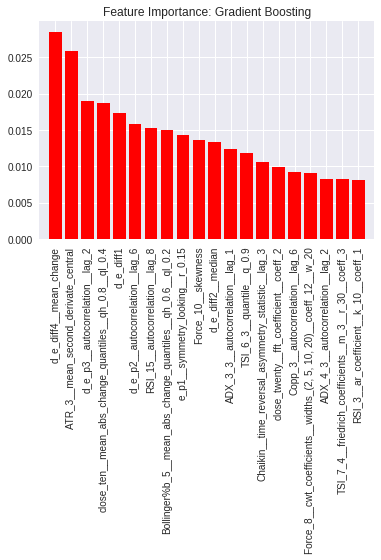

In [ ]:
from sklearn.metrics import classification_report
from scikitplot import plotters as skplt # more flexible import 
import matplotlib.pyplot as plt
%matplotlib inline

# you don't really know wht feature is more important due to multi-collinearity. 
# It gives about 1% more with all the features in place, I think that is already a good
# development. 

gb = GradientBoostingClassifier()
gb.fit(X, y)
features_list = X.columns.values.tolist()
gb_plt = skplt.plot_feature_importances(gb, feature_names=features_list)
gb_plt.set_title('Feature Importance: Gradient Boosting')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Great all I have left to do is run the big ones and see what happens.

gb.fit(X_train, y_train)
preds = gb.predict(X_test)
target_names = ['Below','beat']
print(classification_report(y_test, preds, target_names=target_names))

             precision    recall  f1-score   support

      Below       0.60      0.91      0.72        43
       beat       0.64      0.21      0.32        33

avg / total       0.62      0.61      0.55        76



In [ ]:
# Like normalization, standardization can be useful, and even required in some
# machine learning algorithms when your time series data has input values with differing scales.

from sklearn.preprocessing import StandardScaler

def Standardisation(df):
    listed = list(df)
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df)
    df = pd.DataFrame(scaled)
    df.columns = listed
    return df
